In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .master("spark://spark-master:7077")\
    .appName("prova iniziale")\
    .config("spark.executor.memory", "512m")\
    .getOrCreate()

sc = spark.sparkContext

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/09/02 09:59:14 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
sc.setLogLevel("ERROR")

In [3]:
# !pip install scikit-learn # to be run at the launch of "docker compose up"

In [4]:
import numpy as np
import pandas as pd
import random
import sklearn.datasets #va installato
import time
import matplotlib.pyplot as plt

from pyspark.sql import Row
from pyspark.sql.functions import col
from pyspark.sql.functions import least
from pyspark.sql.functions import mean
from pyspark.sql.functions import stddev
from pyspark.sql.functions import rand
from pyspark.ml.feature import StandardScaler


In [5]:
%%time

prova =  sklearn.datasets.fetch_kddcup99(percent10 = True, as_frame = True)
X = prova.data

n_cols = 38

CPU times: user 4.3 s, sys: 1.11 s, total: 5.41 s
Wall time: 5.41 s


In [6]:
# Function to retrieve a single row.... copied from the internet
def getrows(df, rownums=None): 
    return df.rdd.zipWithIndex().filter(lambda x: x[1] in rownums).map(lambda x: x[0])

# Define the function for the distance between the cluster centers and the pandas dataframe
def distance(xrow, centers, num_cols=n_cols):
    '''Distance between a dataframe.row
    and the broadcasted value list of centers
    in the form of dataframe.row.value:
    
    broadC = sc.broadcast(center_rows).value
    xrow = clean_X.collect()[1]
    '''
    x = np.array(xrow)[:num_cols]
    the_ds = np.zeros(len(centers))
    
    for c in range(len(centers)):
        c_array = np.array(centers[c])[:num_cols]
        dist2 = np.linalg.norm(x - c_array)**2
        the_ds[c] = dist2
        
    return np.min(the_ds)

def find_closest_center(xrow,broadC):
    '''Distance between a dataframe.row
    and the broadcasted list of centers
    in the form of dataframe.row:
    
    broadC = sc.broadcast(center_rows)
    xrow = clean_X.collect()[1]
    '''
    x = np.array(xrow)
    centers = broadC.value
    the_ds = np.zeros(len(centers))
    
    for c in range(len(centers)):
        c_array = np.array(centers[c])
        dist2 = np.linalg.norm(x - c_array)**2
        the_ds[c] = dist2
        
    return np.argmin(the_ds)

def evaluate_l(log_phi, k, G):
    return G * k/log_phi # G = over-oversampling factor

# Function to select a row based on its probability
def select_row(x):
    if x > np.random.uniform(low = 0, high = 1):
        return True
    else:
        return False
    
def if_greater(xrow, centers):
    return min(distance(xrow, centers, 38), xrow.__getitem__('minimum_cost'))

/usr/bin/spark-3.3.2-bin-hadoop3/python/pyspark/sql/pandas/conversion.py:474: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
/usr/bin/spark-3.3.2-bin-hadoop3/python/pyspark/sql/pandas/conversion.py:486: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():



In configuration (k, G, len_df) = (4, 3, 494021)  time spent is 297.94236612319946 seconds
Found 12 centers in 40 iterations
Dataframe had 494021 rows and 41 columns
CPU times: user 1min 59s, sys: 1 s, total: 2min
Wall time: 4min 57s


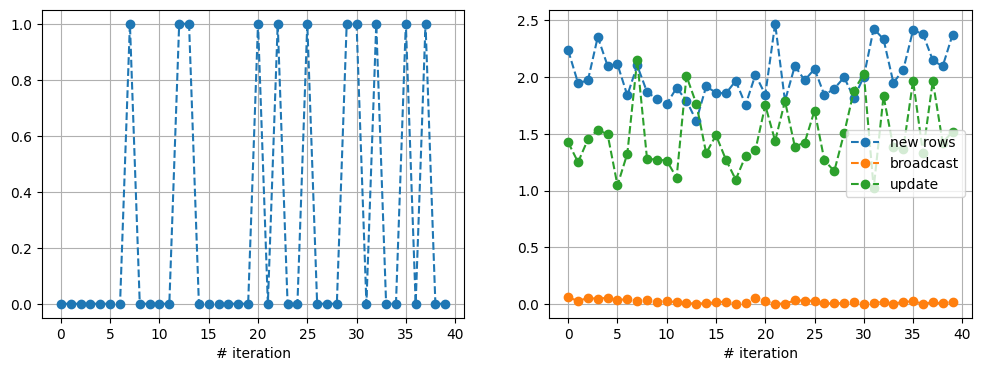

In [7]:
%%time

# Hyperparameters
# ks =      [4,   20,    60,    80,     200,    300]
# len_dfs = [100, 1_000, 5_000, 10_000, 50_000, 100_000]

ks =      [4]
len_dfs = [494_021]

# ks =      [4,   4,     4,     4,      4,      4,       4]
# len_dfs = [100, 1_000, 5_000, 10_000, 50_000, 100_000, 494_021]
Gs = list(np.full(len(ks), 3)) # Giosu factor

cycle = list(zip(ks, Gs, len_dfs))
times = []

for step in cycle:
    time_zero = time.time()
    k = step[0]
    G = step[1]
    len_df = step[2]

    X_smaller = X.iloc[random.sample(range(0, len(X.index)), len_df)]
    spark_X = spark.createDataFrame(X_smaller)
    spark_X.persist() # persist in the memory

    n_rows = spark_X.count()
    n_cols = len(getrows(spark_X, rownums=[0]).collect()[0])

    col_type = np.array(spark_X.dtypes)
    types = col_type[:,1] 
    colnames = col_type[:,0]
    clean_X = spark_X.select([col(colnames[i]) for i in range(len(colnames)) if not types[i] == 'binary'])

    colnames = list(clean_X.dtypes[i][0] for i in range(len(clean_X.dtypes)))

    random_n = [np.random.randint(0, n_rows)]
    random_sample = getrows(clean_X, random_n).collect()

    clean_X = (clean_X.select('*')
               .withColumn('minimum_cost', sum((col(colname)-random_sample[0][colname])**2 for colname in colnames)))

    initial_cost = np.log(clean_X.agg({"minimum_cost": "sum"}).collect()[0][0])
    n_iter = int(initial_cost)

    temp = random_sample[0].asDict()
    temp["minimum_cost"] = 0
    random_sample[0] = Row(**temp)

    bCent = sc.broadcast(random_sample)

    phi_iter = initial_cost
    l = evaluate_l(phi_iter, k, G)

    i = 0
    last_centers = 1
    start_time = time.time()

    # To be removed
    new_centers = []
    time_new_rows = []
    time_broadc = []
    time_update = []

    while i < n_iter:# or len(bCent.value) < k:

        '''
        Nel ciclo for:
            - Evaluate for each row l * d()^2 / phi
            - Sample with that probability
            - Broadcast centers to nodes
            - Evaluate new cost

        Ricordiamoci che distance è già al quadrato e che phi è il logaritmo
        '''

        # Evaluate the probability and select the new rows
        pipì = l/np.exp(phi_iter)
        new_rows = clean_X.select('*').withColumn('random_number', rand(seed=int(time.time())))\
                          .filter(col('random_number') < col('minimum_cost')*pipì).drop('random_number').collect()
        # To be removed
        time_new_rows.append((time.time() - start_time))
        start_time = time.time()
        
        # Update the broadcast
        bCent = sc.broadcast(bCent.value + new_rows)
        # To be removed
        time_broadc.append((time.time() - start_time))
        start_time = time.time()

        # Update the minimum distance
        if len(new_rows) == 1:
            clean_X = clean_X.select('*').withColumn('minimum_cost', least('minimum_cost', sum((col(colname)-bCent.value[0][colname])**2 for colname in colnames) ))

        elif len(new_rows) > 1:
            clean_X = clean_X.select('*').withColumn('dummy', least(*[sum((col(colname)-bCent.value[center][colname])**2 for colname in colnames) for center in range(len(new_rows))] )).\
                      withColumn('minimum_cost', least('minimum_cost', 'dummy')).\
                      drop('dummy')

        last_centers = len(bCent.value)

        # Evaluate new cost
        phi_iter = np.log(clean_X.agg({"minimum_cost": "sum"}).collect()[0][0])

        # To be removed
        time_update.append((time.time() - start_time))
        start_time = time.time()

        i += 1
        # To be removed
        new_centers.append(len(new_rows))

    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
    ax1.plot(new_centers, 'o--', label='# new centers')
    ax1.set_xlabel('# iteration')
    ax1.grid()

    ax2.plot(time_new_rows, 'o--', label='new rows')
    ax2.plot(time_broadc, 'o--', label='broadcast')
    ax2.plot(time_update, 'o--', label='update')
    ax2.set_xlabel('# iteration')
    ax2.legend()
    ax2.grid()

    figname = 'figures/fig_k' + str(step[0]) + '_G' + str(step[1]) + '_len' + str(step[2])
    plt.savefig(figname)
    
    times.append(time.time() - time_zero)
    print('\nIn configuration (k, G, len_df) =', step, ' time spent is', times[-1], 'seconds')
    print('Found', len(bCent.value), 'centers in', n_iter, 'iterations')
    print('Dataframe had', n_rows, 'rows and', n_cols, 'columns')
    
    bCent.destroy()
    spark_X.unpersist() # to unpersist the memory in the workers

